This notebook extracts the surface from the `proc??????_reg1_bulk_beta?_kernel.bin`
files and combines them into a single file for 35 km and 125 km depth,
`reg_1_depth*_bulk_beta?_kernel.npz`.

The code in this notebook is made available under the [GPLv2 license](../LICENSE.md).

In [1]:
from collections import defaultdict
import os
from multiprocessing import Pool

import numpy as np

# Plotting
%matplotlib nbagg
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import cartopy.crs as ccrs

# Fancy progress bars
from tqdm import tqdm

In [2]:
# Some values from constants.h

# R_EARTH is the radius of the bottom of the oceans (radius of Earth in m)
R_EARTH = 6371000
# radius of the Earth in km
R_EARTH_KM = R_EARTH / 1000

FLATTENING_F = 1.0 / 299.8e0
ONE_MINUS_F_SQUARED = (1.0 - FLATTENING_F)**2
FACTOR_TAN = 1.0 / ONE_MINUS_F_SQUARED
TINYVAL = 1.0e-9
NGLL = 5

# number of layers in PREM
NR = 640

# gravitational constant in S.I. units i.e. in m3 kg-1 s-2, or equivalently in N.(m/kg)^2
## DK DK April 2014: switched to the 2010 Committee on Data for Science and Technology (CODATA) recommended value
## DK DK see e.g. http://www.physics.nist.gov/cgi-bin/cuu/Value?bg
## DK DK and http://en.wikipedia.org/wiki/Gravitational_constant
GRAV = 6.67384e-11

# average density in the full Earth to normalize equation
RHOAV = 5514.3

# number of hours per day for rotation rate of the Earth
HOURS_PER_DAY = 24.0
SECONDS_PER_HOUR = 3600.0

# normalized radius of free surface
R_UNIT_SPHERE = 1.0

In [3]:
# NOTE: The mesh should be the same no matter which method is used.
BASEDIR = 'DATA'

In [4]:
# We only need mesh information, so it doesn't matter which of these is used.
cmt = os.path.join(BASEDIR, 'CMTSOLUTION_Love')
sta = os.path.join(BASEDIR, 'STATIONS')
parfile = os.path.join(BASEDIR, 'Par_file_FA')

# Load simulation information

In [5]:
# Obtain simulation parameters
config = {}
with open(parfile, 'r') as f:
    for line in f:
        line = line.split('#')[0]
        if not line:
            continue
        line = line.strip()
        if not line:
            continue

        var, value = [x.strip() for x in line.split('=', maxsplit=1)]
        config[var] = value

NCHUNKS = int(config['NCHUNKS'])
NPROC_XI = int(config['NPROC_XI'])
NPROC_ETA = int(config['NPROC_ETA'])
NEX_XI = int(config['NEX_XI'])
NEX_ETA = int(config['NEX_ETA'])
print("NCHUNKS = %d, NPROC_XI = %d, NEX_XI = %d, NPROC_ETA = %d, NEX_ETA = %d" % (
        NCHUNKS, NPROC_XI, NEX_XI, NPROC_ETA, NEX_ETA))

if NCHUNKS != 6:
    ANGULAR_WIDTH_XI_IN_DEGREES = float(config['ANGULAR_WIDTH_XI_IN_DEGREES'].replace('d', 'e'))
    ANGULAR_WIDTH_ETA_IN_DEGREES = float(config['ANGULAR_WIDTH_ETA_IN_DEGREES'].replace('d', 'e'))
    CENTER_LATITUDE_IN_DEGREES = float(config['CENTER_LATITUDE_IN_DEGREES'].replace('d', 'e'))
    CENTER_LONGITUDE_IN_DEGREES = float(config['CENTER_LONGITUDE_IN_DEGREES'].replace('d', 'e'))
    GAMMA_ROTATION_AZIMUTH = float(config['GAMMA_ROTATION_AZIMUTH'].replace('d', 'e'))
    print("xi_width = %f, eta_width = %f; clat = %f, clon = %f; grot = %f" % (
        ANGULAR_WIDTH_XI_IN_DEGREES, ANGULAR_WIDTH_ETA_IN_DEGREES,
        CENTER_LATITUDE_IN_DEGREES, CENTER_LONGITUDE_IN_DEGREES, GAMMA_ROTATION_AZIMUTH))
else:
    ANGULAR_WIDTH_XI_IN_DEGREES = ANGULAR_WIDTH_ETA_IN_DEGREES = 90.0
    CENTER_LATITUDE_IN_DEGREES = CENTER_LONGITUDE_IN_DEGREES = GAMMA_ROTATION_AZIMUTH = None

ANGULAR_WIDTH_XI_RAD = np.deg2rad(ANGULAR_WIDTH_XI_IN_DEGREES)
ANGULAR_WIDTH_ETA_RAD = np.deg2rad(ANGULAR_WIDTH_ETA_IN_DEGREES)

NCHUNKS = 6, NPROC_XI = 8, NEX_XI = 256, NPROC_ETA = 8, NEX_ETA = 256


# Ellipticity Correction

In [6]:
# This is pretty cool; automatic Fortran support...
%load_ext fortranmagic

In [7]:
%%fortran
! specfem3d_globe/src/shared/intgrl.f90
! The subroutines have been modified slightly to include the correct intent.

  subroutine intgrl(sumval,r,nir,ner,f,s1,s2,s3)

! Computes the integral of f[i]*r[i]*r[i] from i=nir to i=ner for
! radii values as in model PREM_an640

  implicit none

! Argument variables
  integer :: ner,nir
  double precision, dimension(640), intent(in) :: f, r
  double precision, dimension(640), intent(inout) :: s1, s2, s3  ! Work arrays
  double precision, intent(out) :: sumval

! Local variables
  double precision, parameter :: third = 1.0d0/3.0d0
  double precision, parameter :: fifth = 1.0d0/5.0d0
  double precision, parameter :: sixth = 1.0d0/6.0d0

  double precision :: rji,yprime(640)
  double precision :: s1l,s2l,s3l

  integer :: i,j,n,kdis(12)
  integer :: ndis,nir1

  data kdis/163,323,336,517,530,540,565,590,609,619,626,633/

  ndis = 12
  n = 640

  call deriv(f,yprime,n,r,ndis,kdis,s1,s2,s3)

  nir1 = nir + 1
  sumval = 0.0d0
  do i=nir1,ner
    j = i-1
    rji = r(i) - r(j)
    s1l = s1(j)
    s2l = s2(j)
    s3l = s3(j)
    sumval = sumval + r(j)*r(j)*rji*(f(j) &
              + rji*(0.5d0*s1l + rji*(third*s2l + rji*0.25d0*s3l))) &
              + 2.0d0*r(j)*rji*rji*(0.5d0*f(j) + rji*(third*s1l + rji*(0.25d0*s2l + rji*fifth*s3l))) &
              + rji*rji*rji*(third*f(j) + rji*(0.25d0*s1l + rji*(fifth*s2l + rji*sixth*s3l)))
  enddo

  end subroutine intgrl

! -------------------------------

  subroutine deriv(y,yprime,n,r,ndis,kdis,s1,s2,s3)

  implicit none

! Argument variables
  integer, intent(in) :: n,ndis
  integer, dimension(ndis), intent(in) :: kdis
  double precision, dimension(n), intent(in) :: r
  double precision, dimension(n), intent(inout) :: s1, s2, s3
  double precision, dimension(n), intent(in) :: y
  double precision, dimension(n), intent(out) :: yprime

! Local variables
  integer :: i,j,j1,j2
  integer :: k,nd,ndp
  double precision :: a0,b0,b1
  double precision :: f(3,1000),h,h2,h2a
  double precision :: h2b,h3a,ha,s13
  double precision :: s21,s32,yy(3)

  yy(1) = 0.d0
  yy(2) = 0.d0
  yy(3) = 0.d0

  ndp=ndis+1
  do 3 nd = 1,ndp
  if (nd == 1) goto 4
  if (nd == ndp) goto 5
  j1=kdis(nd-1)+1
  j2=kdis(nd)-2
  goto 6
    4 j1 = 1
  j2=kdis(1)-2
  goto 6
    5 j1=kdis(ndis)+1
  j2=n-2
    6 if ((j2+1-j1)>0) goto 11
  j2=j2+2
  yy(1)=(y(j2)-y(j1))/(r(j2)-r(j1))
  s1(j1)=yy(1)
  s1(j2)=yy(1)
  s2(j1)=yy(2)
  s2(j2)=yy(2)
  s3(j1)=yy(3)
  s3(j2)=yy(3)
  goto 3
   11 a0=0.0d0
  if (j1 == 1) goto 7
  h=r(j1+1)-r(j1)
  h2=r(j1+2)-r(j1)
  yy(1)=h*h2*(h2-h)
  h=h*h
  h2=h2*h2
  b0=(y(j1)*(h-h2)+y(j1+1)*h2-y(j1+2)*h)/yy(1)
  goto 8
 7 b0=0.0d0
 8 b1=b0

  if (j2 > 1000) stop 'Error in subroutine deriv for j2'

  do i=j1,j2
    h=r(i+1)-r(i)
    yy(1)=y(i+1)-y(i)
    h2=h*h
    ha=h-a0
    h2a=h-2.0d0*a0
    h3a=2.0d0*h-3.0d0*a0
    h2b=h2*b0
    s1(i)=h2/ha
    s2(i)=-ha/(h2a*h2)
    s3(i)=-h*h2a/h3a
    f(1,i)=(yy(1)-h*b0)/(h*ha)
    f(2,i)=(h2b-yy(1)*(2.0d0*h-a0))/(h*h2*h2a)
    f(3,i)=-(h2b-3.0d0*yy(1)*ha)/(h*h3a)
    a0=s3(i)
    b0=f(3,i)
  enddo

  i=j2+1
  h=r(i+1)-r(i)
  yy(1)=y(i+1)-y(i)
  h2=h*h
  ha=h-a0
  h2a=h*ha
  h2b=h2*b0-yy(1)*(2.d0*h-a0)
  s1(i)=h2/ha
  f(1,i)=(yy(1)-h*b0)/h2a
  ha=r(j2)-r(i+1)
  yy(1)=-h*ha*(ha+h)
  ha=ha*ha
  yy(1)=(y(i+1)*(h2-ha)+y(i)*ha-y(j2)*h2)/yy(1)
  s3(i)=(yy(1)*h2a+h2b)/(h*h2*(h-2.0d0*a0))
  s13=s1(i)*s3(i)
  s2(i)=f(1,i)-s13

  do j=j1,j2
    k=i-1
    s32=s3(k)*s2(i)
    s1(i)=f(3,k)-s32
    s21=s2(k)*s1(i)
    s3(k)=f(2,k)-s21
    s13=s1(k)*s3(k)
    s2(k)=f(1,k)-s13
    i=k
  enddo

  s1(i)=b1
  j2=j2+2
  s1(j2)=yy(1)
  s2(j2)=yy(2)
  s3(j2)=yy(3)
 3 continue

  do i = 1,n
    yprime(i)=s1(i)
  enddo

  end subroutine deriv

In [8]:
%%fortran
! specfem3d_globe/src/shared/spline_routines.f90

! compute spline coefficients

  subroutine spline_construction(xpoint,ypoint,npoint,tangent_first_point,tangent_last_point,spline_coefficients)

  implicit none

! tangent to the spline imposed at the first and last points
  double precision, intent(in) :: tangent_first_point,tangent_last_point

! number of input points and coordinates of the input points
  integer, intent(in) :: npoint
  double precision, dimension(npoint), intent(in) :: xpoint,ypoint

! spline coefficients output by the routine
  double precision, dimension(npoint), intent(out) :: spline_coefficients

  integer :: i

  double precision, dimension(:), allocatable :: temporary_array

  allocate(temporary_array(npoint))

  spline_coefficients(1) = - 1.d0 / 2.d0

  temporary_array(1) = (3.d0/(xpoint(2)-xpoint(1)))*((ypoint(2)-ypoint(1))/(xpoint(2)-xpoint(1))-tangent_first_point)

  do i = 2,npoint-1

    spline_coefficients(i) = ((xpoint(i)-xpoint(i-1))/(xpoint(i+1)-xpoint(i-1))-1.d0) &
       / ((xpoint(i)-xpoint(i-1))/(xpoint(i+1)-xpoint(i-1))*spline_coefficients(i-1)+2.d0)

    temporary_array(i) = (6.d0*((ypoint(i+1)-ypoint(i))/(xpoint(i+1)-xpoint(i)) &
       - (ypoint(i)-ypoint(i-1))/(xpoint(i)-xpoint(i-1)))/(xpoint(i+1)-xpoint(i-1)) &
       - (xpoint(i)-xpoint(i-1))/(xpoint(i+1)-xpoint(i-1))*temporary_array(i-1)) &
       / ((xpoint(i)-xpoint(i-1))/(xpoint(i+1)-xpoint(i-1))*spline_coefficients(i-1)+2.d0)

  enddo

  spline_coefficients(npoint) = ((3.d0/(xpoint(npoint)-xpoint(npoint-1))) &
      * (tangent_last_point-(ypoint(npoint)-ypoint(npoint-1))/(xpoint(npoint)-xpoint(npoint-1))) &
      - 1.d0/2.d0*temporary_array(npoint-1))/(1.d0/2.d0*spline_coefficients(npoint-1)+1.d0)

  do i = npoint-1,1,-1
    spline_coefficients(i) = spline_coefficients(i)*spline_coefficients(i+1) + temporary_array(i)
  enddo

  deallocate(temporary_array)

  end subroutine spline_construction

In [9]:
%%fortran
! specfem3d_globe/src/shared/spline_routines.f90

! evaluate a spline

  subroutine spline_evaluation(xpoint,ypoint,spline_coefficients,npoint,x_evaluate_spline,y_spline_obtained)

  implicit none

! number of input points and coordinates of the input points
  integer, intent(in) :: npoint
  double precision, dimension(npoint), intent(in) :: xpoint,ypoint

! spline coefficients to use
  double precision, dimension(npoint), intent(in) :: spline_coefficients

! abscissa at which we need to evaluate the value of the spline
  double precision, intent(in):: x_evaluate_spline

! ordinate evaluated by the routine for the spline at this abscissa
  double precision, intent(out):: y_spline_obtained

  integer :: index_loop,index_lower,index_higher

  double precision :: coef1,coef2

! initialize to the whole interval
  index_lower = 1
  index_higher = npoint

! determine the right interval to use, by dichotomy
  do while (index_higher - index_lower > 1)
! compute the middle of the interval
    index_loop = (index_higher + index_lower) / 2
    if (xpoint(index_loop) > x_evaluate_spline) then
      index_higher = index_loop
    else
      index_lower = index_loop
    endif
  enddo

! test that the interval obtained does not have a size of zero
! (this could happen for instance in the case of duplicates in the input list of points)
  if (xpoint(index_higher) == xpoint(index_lower)) stop 'incorrect interval found in spline evaluation'

  coef1 = (xpoint(index_higher) - x_evaluate_spline) / (xpoint(index_higher) - xpoint(index_lower))
  coef2 = (x_evaluate_spline - xpoint(index_lower)) / (xpoint(index_higher) - xpoint(index_lower))

  y_spline_obtained = coef1*ypoint(index_lower) + coef2*ypoint(index_higher) + &
        ((coef1**3 - coef1)*spline_coefficients(index_lower) + &
         (coef2**3 - coef2)*spline_coefficients(index_higher))*((xpoint(index_higher) - xpoint(index_lower))**2)/6.d0

  end subroutine spline_evaluation

! --------------

! This subroutine has been created from the specfem3d_globe version
! to be able to produce multiple evaluated points from one call. The
! reason is it avoids the Python-Fortran bridge, which slows things
! down somewhat.

  subroutine spline_evaluation_array(xpoint,ypoint,spline_coefficients,npoint,x_evaluate_spline,y_spline_obtained,neval)

  implicit none

! number of input points and coordinates of the input points
  integer, intent(in) :: npoint, neval
  double precision, dimension(npoint), intent(in) :: xpoint,ypoint

! spline coefficients to use
  double precision, dimension(npoint), intent(in) :: spline_coefficients

! abscissa at which we need to evaluate the value of the spline
  double precision, dimension(neval), intent(in):: x_evaluate_spline

! ordinate evaluated by the routine for the spline at this abscissa
  double precision, dimension(neval), intent(out):: y_spline_obtained

  integer :: i

  do i = 1, neval
    call spline_evaluation(xpoint,ypoint,spline_coefficients,npoint,x_evaluate_spline(i),y_spline_obtained(i))
  enddo
end subroutine

In [10]:
# Based on specfem3d_globe, but vectorized.

def prem_density(x, ONE_CRUST, RICB, RCMB, RTOPDDOUBLEPRIME, R600, R670, R220,
                 R771, R400, R80, RMOHO, RMIDDLE_CRUST, ROCEAN):
    # Compute real physical radius in meters.
    r = x * R_EARTH

    # Calculates density according to radius.
    rho = np.empty_like(r)

    m = r <= RICB
    xm = x[m]
    rho[m] = 13.0885 - 8.8381 * xm * xm

    m = (RICB < r) & (r <= RCMB)
    xm = x[m]
    rho[m] = 12.5815 - 1.2638 * xm - 3.6426 * xm * xm - 5.5281 * xm * xm * xm

    m = (RCMB < r) & (r <= RTOPDDOUBLEPRIME)
    xm = x[m]
    rho[m] = 7.9565 - 6.4761 * xm + 5.5283 * xm * xm - 3.0807 * xm * xm * xm

    m = (RTOPDDOUBLEPRIME < r) & (r <= R771)
    xm = x[m]
    rho[m] = 7.9565 - 6.4761 * xm + 5.5283 * xm * xm - 3.0807 * xm * xm * xm

    m = (R771 < r) & (r <= R670)
    xm = x[m]
    rho[m] = 7.9565 - 6.4761 * xm + 5.5283 * xm * xm - 3.0807 * xm * xm * xm

    m = (R670 < r) & (r <= R600)
    xm = x[m]
    rho[m] = 5.3197 - 1.4836 * xm

    m = (R600 < r) & (r <= R400)
    xm = x[m]
    rho[m] = 11.2494 - 8.0298 * xm

    m = (R400 < r) & (r <= R220)
    xm = x[m]
    rho[m] = 7.1089 - 3.8045 * xm

    m = (R220 < r) & (r <= R80)
    xm = x[m]
    rho[m] = 2.6910 + 0.6924 * xm

    m = (R80 < r) & (r <= RMOHO)
    xm = x[m]
    rho[m] = 2.6910 + 0.6924 * xm

    m = (RMOHO < r) & (r <= RMIDDLE_CRUST)
    if ONE_CRUST:
        rho[m] = 2.6
    else:
        rho[m] = 2.9

    m = (RMIDDLE_CRUST < r) & (r <= ROCEAN)
    rho[m] = 2.6

    m = (ROCEAN < r)
    rho[m] = 2.6

    rho *= 1000.0 / RHOAV

    return rho

In [11]:
def make_ellipticity(ONE_CRUST):
    """
    Create a spline for the ellipticity profile in PREM.

    Radius and density are non-dimensional.
    Based on specfem3d_globe, but vectorized in some places.
    """
    # Radius of the Earth for gravity calculation
    R_EARTH_ELLIPTICITY = 6371000.0
    # Radius of the ocean floor for gravity calculation
    ROCEAN_ELLIPTICITY = 6368000.0

    # PREM
    ROCEAN = 6368000.0
    RMIDDLE_CRUST = 6356000.0
    RMOHO = 6346600.0
    R80 = 6291000.0
    R220 = 6151000.0
    R400 = 5971000.0
    R600 = 5771000.0
    R670 = 5701000.0
    R771 = 5600000.0
    RTOPDDOUBLEPRIME = 3630000.0
    RCMB = 3480000.0
    RICB = 1221000.0

    # non-dimensionalize
    r_icb = RICB / R_EARTH_ELLIPTICITY
    r_cmb = RCMB / R_EARTH_ELLIPTICITY
    r_topddoubleprime = RTOPDDOUBLEPRIME / R_EARTH_ELLIPTICITY
    r_771 = R771 / R_EARTH_ELLIPTICITY
    r_670 = R670 / R_EARTH_ELLIPTICITY
    r_600 = R600 / R_EARTH_ELLIPTICITY
    r_400 = R400 / R_EARTH_ELLIPTICITY
    r_220 = R220 / R_EARTH_ELLIPTICITY
    r_80 = R80 / R_EARTH_ELLIPTICITY
    r_moho = RMOHO / R_EARTH_ELLIPTICITY
    r_middle_crust = RMIDDLE_CRUST / R_EARTH_ELLIPTICITY
    r_ocean = ROCEAN_ELLIPTICITY / R_EARTH_ELLIPTICITY
    r_0 = 1.0

    r = np.empty(NR)
    r[0:163] = r_icb * np.arange(163) / 162
    r[163:323] = r_icb + (r_cmb - r_icb) * np.arange(160) / 159
    r[323:336] = r_cmb + (r_topddoubleprime - r_cmb) * np.arange(13) / 12
    r[336:517] = (r_topddoubleprime +
                  (r_771 - r_topddoubleprime) * np.arange(181) / 180)
    r[517:530] = r_771 + (r_670 - r_771) * np.arange(13) / 12
    r[530:540] = r_670 + (r_600 - r_670) * np.arange(10) / 9
    r[540:565] = r_600 + (r_400 - r_600) * np.arange(25) / 24
    r[565:590] = r_400 + (r_220 - r_400) * np.arange(25) / 24
    r[590:609] = r_220 + (r_80 - r_220) * np.arange(19) / 18
    r[609:619] = r_80 + (r_moho - r_80) * np.arange(10) / 9
    r[619:626] = r_moho + (r_middle_crust - r_moho) * np.arange(7) / 6
    r[626:633] = r_middle_crust + (r_ocean - r_middle_crust) * np.arange(7) / 6
    r[633:NR] = r_ocean + (r_0 - r_ocean) * np.arange(7) / 6

    # Use PREM to get the density profile for ellipticity (fine for other 1D
    # reference models).
    rho = prem_density(r, ONE_CRUST, RICB, RCMB, RTOPDDOUBLEPRIME,
                       R600, R670, R220, R771, R400, R80, RMOHO,
                       RMIDDLE_CRUST, ROCEAN)
    radau = rho * r * r

    i_rho = np.empty(NR)
    i_radau = np.empty(NR)
    # Work arrays
    s1 = np.empty(NR)
    s2 = np.empty(NR)
    s3 = np.empty(NR)

    for i in range(1, NR):
        i_rho[i] = intgrl(r, 1, i + 1, rho, s1, s2, s3)
        i_radau[i] = intgrl(r, 1, i + 1, radau, s1, s2, s3)

    # Radau approximation of Clairaut's equation for first-order terms of
    # ellipticity, see e.g. Jeffreys H.. The figures of rotating planets,
    # Mon. Not. R. astr. Soc., vol. 113, p. 97-105 (1953). The Radau
    # approximation is mentioned on page 97. For more details see Section
    # 14.1.2 in Dahlen and Tromp (1998) (see also in file
    # ellipticity_equations_from_Dahlen_Tromp_1998.pdf in the "doc"
    # directory of the code).
    with np.errstate(divide='ignore'):  # For first element, r = 0
        z = (2 / 3) * i_radau / (i_rho * r * r)
        # this comes from equation (14.19) in Dahlen and Tromp (1998)
        eta = (25 / 4) * (1 - (3 / 2) * z)**2 - 1
        k = eta / r**3
    eta[0] = 0.0
    k[0] = 0.0

    bom = 2 * np.pi / (HOURS_PER_DAY * SECONDS_PER_HOUR)

    # non-dimensionalized value
    bom = bom / np.sqrt(np.pi * GRAV * RHOAV)

    epsilonval = np.empty(NR)
    # this is the equation right above (14.21) in Dahlen and Tromp (1998)
    g_a = 4.0 * i_rho[NR - 1]
    epsilonval[NR - 1] = ((5 / 2) * bom**2 * R_UNIT_SPHERE /
                          (g_a * (eta[NR - 1] + 2)))

    for i in range(NR - 1):
        exponentval = intgrl(r, i + 1, NR, k, s1, s2, s3)
        epsilonval[i] = epsilonval[NR - 1] * np.exp(-exponentval)

    rspl = np.empty(NR)
    espl = np.empty(NR)
    # get ready to spline epsilonval
    nspl = 1
    rspl[0] = r[0]
    espl[0] = epsilonval[0]
    for i in range(1, NR):
        if r[i] != r[i - 1]:
            rspl[nspl] = r[i]
            espl[nspl] = epsilonval[i]
            nspl += 1
    rspl = rspl[:nspl]
    espl = espl[:nspl]

    # spline epsilonval
    yp1 = 0.0
    ypn = (5.0 / 2.0) * bom**2 / g_a - 2 * epsilonval[NR - 1]
    espl2 = spline_construction(rspl, espl, yp1, ypn, nspl)

    return rspl, espl, espl2

In [12]:
def revert_ellipticity(r, theta, phi, rspl, espl, espl2):
    """
    Revert ellipticity and go back to a spherical Earth.
    """

    cost = np.cos(theta)
    # This is the Legendre polynomial of degree two, P2(cos(theta)), see the
    # discussion above eq (14.4) in Dahlen and Tromp (1998).
    p20 = 0.5 * (3 * cost * cost - 1)

    # Get ellipticity using spline evaluation.
    ell = spline_evaluation_array(rspl, espl, espl2, r)

    # This is eq (14.4) in Dahlen and Tromp (1998).
    factor = 1 - (2 / 3) * ell * p20

    # Remove ellipticity factor.
    return r / factor

In [13]:
ellipticity_info = make_ellipticity(True)  # ONE_CRUST = True for s40rts

# Topography 

    #--------------------------------------------------------------------------------------------------
    # ETOPO
    #
    # Global Gridded Elevation Data
    #
    # by default (constants.h), it uses a smoothed ETOPO 4 dataset
    #--------------------------------------------------------------------------------------------------

In [14]:
#---  ETOPO4 4-minute model
# Size of topography and bathymetry file.
NX_BATHY = 5400
NY_BATHY = 2700
# Resolution of topography file in minutes.
RESOLUTION_TOPO_FILE = 4
# Path of the topography file.
PATHNAME_TOPO_FILE = 'DATA/topo_bathy/topo_bathy_etopo4_smoothed_window_7.bin'
# The code will print an error message and stop if it finds that the topography
# input file contains values outside this range. We take a safety margin just in
# case of a smoothed or modified model, which can locally create slightly different values
TOPO_MINIMUM = -11200  # (max depth in m, Mariana trench)
TOPO_MAXIMUM = +9000  # (height in m, Mount Everest)

In [15]:
with open(PATHNAME_TOPO_FILE, 'rb') as f:
    magic = np.fromfile(f, count=1, dtype='<i2')
    assert magic == 0x1234, 'Topography file uses incorrect byte-order.'
    ibathy_topo = np.fromfile(PATHNAME_TOPO_FILE,
                              count=NX_BATHY * NY_BATHY,
                              dtype='<i2')
ibathy_topo = ibathy_topo.reshape((NX_BATHY, NY_BATHY), order='F')
assert not(np.any(ibathy_topo < TOPO_MINIMUM) or np.any(ibathy_topo > TOPO_MAXIMUM)), \
    'Error reading topography: value exceeds min/max topography bounds'

In [16]:
lat_topo = np.arange(90, -90.01, -RESOLUTION_TOPO_FILE / 60)
lon_topo = np.arange(0, 360.01, RESOLUTION_TOPO_FILE / 60)
lon_topo, lat_topo = np.meshgrid(lon_topo, lat_topo)

**Note**: Something is wrong with Cartopy's Mollweide below,
but the topography data appears correct.

<IPython.core.display.Javascript object>


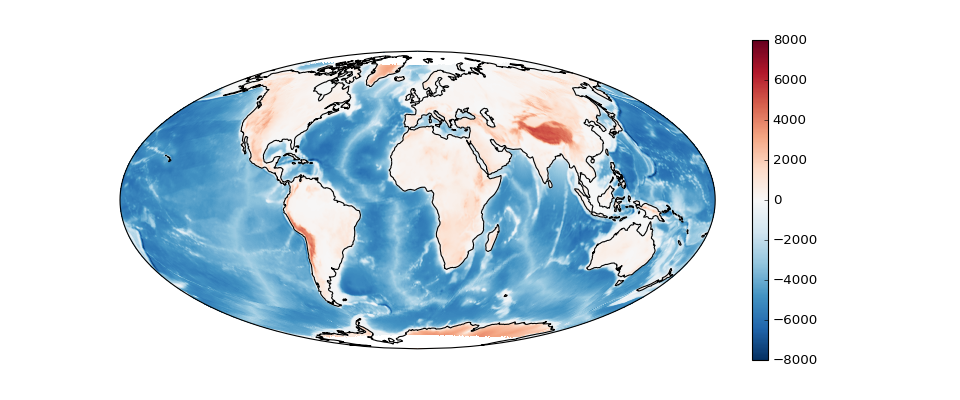

In [17]:
fig = plt.figure(figsize=(12, 5))
ax = plt.axes(projection=ccrs.Mollweide())
ax.set_global()
ax.coastlines()

mesh = ax.pcolormesh(lon_topo, lat_topo, ibathy_topo.T, transform=ccrs.PlateCarree(),
                     vmin=-8e3, vmax=8e3, cmap='RdBu_r')
fig.colorbar(mesh);

In [18]:
def get_topo_bathy(xlat, xlon):
    """
    Get elevation or ocean depth in meters at a given latitude and longitude.
    """

    assert isinstance(xlat, np.ndarray)
    assert isinstance(xlon, np.ndarray)
    assert xlat.ndim == xlon.ndim
    assert xlat.shape == xlon.shape

    # Initialize elevation.
    value = np.zeros_like(xlat)

    # Longitude within range [0,360] degrees.
    xlo = xlon.copy()
    xlo[xlo < 0] += 360
    xlo[xlo > 360] -= 360

    # Compute number of samples per degree.
    samples_per_degree_topo = RESOLUTION_TOPO_FILE / 60.0

    # Compute offset in data file and avoid edge effects.
    iadd1 = 1 + ((90.0 - xlat) // samples_per_degree_topo).astype(np.intp)
    iadd1[iadd1 < 1] = 1
    iadd1[iadd1 > NY_BATHY] = NY_BATHY

    iel1 = (xlo / samples_per_degree_topo).astype(np.intp)
    iel1[(iel1 <= 0) | (iel1 > NX_BATHY)] = NX_BATHY

    # Use bilinear interpolation rather nearest point interpolation.

    lon_corner = iel1 * samples_per_degree_topo
    lat_corner = 90.0 - iadd1 * samples_per_degree_topo

    ratio_lon = (xlo - lon_corner) / samples_per_degree_topo
    ratio_lat = (xlat - lat_corner) / samples_per_degree_topo

    ratio_lon[ratio_lon < 0.0] = 0.0
    ratio_lon[ratio_lon > 1.0] = 1.0
    ratio_lat[ratio_lat < 0.0] = 0.0
    ratio_lat[ratio_lat > 1.0] = 1.0

    # Interpolate for points within boundaries.
    mask = (iadd1 <= NY_BATHY - 1) & (iel1 <= NX_BATHY - 1)
    value[mask] = (
        ibathy_topo[iel1[mask] - 1, iadd1[mask] - 1] * (1 - ratio_lon[mask]) * (1 - ratio_lat[mask]) +
        ibathy_topo[iel1[mask], iadd1[mask] - 1] * ratio_lon[mask] * (1 - ratio_lat[mask]) +
        ibathy_topo[iel1[mask], iadd1[mask]] * ratio_lon[mask] * ratio_lat[mask] +
        ibathy_topo[iel1[mask] - 1, iadd1[mask]] * (1 - ratio_lon[mask]) * ratio_lat[mask]
    )

    # Interpolate for points on longitude border.
    mask = ~mask & (iadd1 <= NY_BATHY - 1) & (iel1 == NX_BATHY)
    value[mask] = (
        ibathy_topo[iel1[mask] - 1, iadd1[mask] - 1] * (1 - ratio_lon[mask]) * (1 - ratio_lat[mask]) +
        ibathy_topo[0, iadd1[mask] - 1] * ratio_lon[mask] * (1 - ratio_lat[mask]) +
        ibathy_topo[0, iadd1[mask]] * ratio_lon[mask] * ratio_lat[mask] +
        ibathy_topo[iel1[mask] - 1, iadd1[mask]] * (1 - ratio_lon[mask]) * ratio_lat[mask]
    )

    # For points on latitude boundaries.
    mask = ~mask
    value[mask] = ibathy_topo[iel1[mask] - 1, iadd1[mask] - 1]

    return value

Original code:
\begin{align}
 \gamma &= (r - R_{220}) / (1 - R_{220}) \\
 r_\text{topo} &= r (1 + \frac{\gamma e}{r}) \\
\end{align}

Reversed algorithm:
\begin{align}
 r_\text{topo} &= r \left( 1 + \frac{(r - R_{220})e}{(1 - R_{220}) r} \right) \\
 r_\text{topo} &= r + \frac{(r - R_{220})e}{(1 - R_{220})} \\
 r_\text{topo} &= r \frac{(1 - R_{220})}{(1 - R_{220})} + \frac{(r - R_{220})e}{(1 - R_{220})} \\
 r_\text{topo} &= \frac{r (1 - R_{220}) + (r - R_{220})e}{(1 - R_{220})} \\
 r_\text{topo} &= \frac{r - R_{220} r + r e - R_{220} e}{(1 - R_{220})} \\
 r_\text{topo} &= \frac{(1 + e - R_{220}) r - R_{220} e}{(1 - R_{220})} \\
 (1 - R_{220}) r_\text{topo} &= (1 + e - R_{220}) r - R_{220} e \\
 (1 - R_{220}) r_\text{topo} + R_{220} e &= (1 + e - R_{220}) r \\
 r &= \frac{(1 - R_{220}) r_\text{topo} + R_{220} e}{(1 + e - R_{220})} \\
 r &= \frac{\gamma r_\text{topo} + R_{220} e}{\gamma + e} & \gamma &= 1 - R_{220}
\end{align}

In [19]:
def remove_topography(r, lat, lon, R220):
    # The reverse of add_topography(); it's not totally correct since
    # normally topography is applied to full elements, not GLL points.

    # Compute elevation at current point.
    elevation = get_topo_bathy(lat, lon)

    # Non-dimensionalize the elevation and d220, which are in metres.
    elevation = elevation / R_EARTH
    R220 = R220 / R_EARTH

    # Stretching topography between d220 and the surface.
    gamma = R_UNIT_SPHERE - R220

    # Remove elevation from all the points of that element.
    return (gamma * r + R220 * elevation) / (gamma + elevation)

# Data loading functions

In [20]:
def read_fortran_record(f, dtype='f4', count=1):
    dtype = np.dtype(dtype)
    count_dtype = np.dtype('u4').newbyteorder(dtype.byteorder)

    n1 = np.fromfile(f, dtype=count_dtype, count=1)
    assert n1 == count * dtype.itemsize, \
        'Expected: %u, Got: %u' % (count * dtype.itemsize, n1)

    data = np.fromfile(f, dtype=dtype, count=count)

    n2 = np.fromfile(f, dtype=count_dtype, count=1)
    assert n2 == count * dtype.itemsize, \
        'Expected: %u, Got: %u' % (count * dtype.itemsize, n2)

    return data

In [21]:
def load_mesh(f):
    nspec = read_fortran_record(f, 'u4')
    nglob = read_fortran_record(f, 'u4')
    nelem = NGLL * NGLL * NGLL * nspec

    xstore = read_fortran_record(f, count=nglob)
    ystore = read_fortran_record(f, count=nglob)
    zstore = read_fortran_record(f, count=nglob)
    ibool = read_fortran_record(f, dtype='u4', count=nelem).reshape((NGLL, NGLL, NGLL, nspec),
                                                                    order='F')

    rstore = np.sqrt(xstore**2 + ystore**2 + zstore**2)
    thetastore = np.arctan2(np.hypot(xstore, ystore), zstore)
    phistore = np.arctan2(ystore, xstore)
    phistore[phistore < 0] += 2 * np.pi
    thetastore = np.arctan(FACTOR_TAN * np.cos(thetastore) / np.maximum(TINYVAL, np.sin(thetastore)))

    latstore = np.rad2deg(thetastore)
    lonstore = np.rad2deg(phistore)

    return rstore, latstore, lonstore, ibool

In [22]:
def load_slice(topo_dir, kernel_dir, slice_number, prop):
    filename = os.path.join(topo_dir, 'proc%06d_reg1_solver_data.bin' % (slice_number, ))
    with open(filename, 'rb') as f:
        r, lat, lon, ibool = load_mesh(f)
    assert np.all(ibool != -1)

    filename = os.path.join(kernel_dir, 'proc%06d_reg1_%s_kernel.bin' % (slice_number, prop))
    with open(filename, 'rb') as f:
        data = read_fortran_record(f, count=ibool.size).reshape((NGLL, NGLL, NGLL, -1),
                                                                order='F')

    return r, lat, lon, ibool, data

In [23]:
def find_surface(local_to_global, global_to_local, nglob, start_point):
    surface = np.zeros(nglob, dtype=np.bool_)
    points_to_check = list(global_to_local[start_point + 1])
    while points_to_check:
        i, j, k, ispec = points_to_check.pop()
        iglob = local_to_global[i, j, k, ispec] - 1
        if not surface[iglob]:
            surface[iglob] = True
            points_to_check.extend(global_to_local[iglob + 1])

        # Points to left/right
        if i > 0:
            iglob = local_to_global[i - 1, j, k, ispec] - 1
            if not surface[iglob]:
                surface[iglob] = True
                points_to_check.extend(global_to_local[iglob + 1])
        if i < 4:
            iglob = local_to_global[i + 1, j, k, ispec] - 1
            if not surface[iglob]:
                surface[iglob] = True
                points_to_check.extend(global_to_local[iglob + 1])

        # Points above/below
        if j > 0:
            iglob = local_to_global[i, j - 1, k, ispec] - 1
            if not surface[iglob]:
                surface[iglob] = True
                points_to_check.extend(global_to_local[iglob + 1])
        if j < 4:
            iglob = local_to_global[i, j + 1, k, ispec] - 1
            if not surface[iglob]:
                surface[iglob] = True
                points_to_check.extend(global_to_local[iglob + 1])

    return surface

In [24]:
def find_neighbours(local_to_global, global_to_local, index):
    neighbours = np.empty(index.shape + (5, ), dtype=np.intp)
    neighbours.fill(-1)
    neighbours[:, 0] = index

    for ineigh, iglob in enumerate(index):
        for i, j, k, ispec in global_to_local[iglob + 1]:
            # Points to left/right
            if i > 0:
                iglob_left = local_to_global[i - 1, j, k, ispec] - 1
                neighbours[ineigh, 1] = iglob_left
            if i < 4:
                iglob_right = local_to_global[i + 1, j, k, ispec] - 1
                neighbours[ineigh, 2] = iglob_right

            # Points above/below
            if j > 0:
                iglob_below = local_to_global[i, j - 1, k, ispec] - 1
                neighbours[ineigh, 3] = iglob_below
            if j < 4:
                iglob_above = local_to_global[i, j + 1, k, ispec] - 1
                neighbours[ineigh, 4] = iglob_above

    return neighbours

In [25]:
def create_gridded_surface(r, lat, lon, data, global_to_local, surface_index, neighbours, shape=None):
    if shape is not None:
        nx, ny = shape
    else:
        nx = NEX_XI // NPROC_XI * (NGLL - 1) + 1
        ny = NEX_ETA // NPROC_ETA * (NGLL - 1) + 1

    lat_grid = np.empty((nx + 1, ny + 1))
    lon_grid = np.empty_like(lat_grid)
    r_grid = np.empty((nx, ny))
    data_grid = np.empty_like(r_grid)

    # To convert global neighbours into surface neighbours.
    global_to_surf = {iglob: ineed for ineed, iglob in enumerate(surface_index)}

    # Bottom is where no neighbours below.
    bottom = neighbours[:, 3] == -1

    # Left edge is where no neighbours to left.
    bottom_left = np.where(bottom & (neighbours[:, 1] == -1))[0]
    assert len(bottom_left) == 1
    bottom_left = surface_index[bottom_left[0]]

    # Right edge is where no neighbours to right.
    bottom_right = np.where(bottom & (neighbours[:, 2] == -1))[0]
    assert len(bottom_right) == 1
    bottom_right = surface_index[bottom_right[0]]

    # Note, "bottom-left" is arbitrary, so this is minimum GLL point.
    point = bottom_left
    # Go left-to-right:
    for x in range(nx):
        bottom_point_this_column = point

        # Go bottom-to-top:
        for y in range(ny):
            ineigh = global_to_surf[point]
            iglob, iglob_left, iglob_right, iglob_below, iglob_above = neighbours[ineigh, :]
            assert iglob == point

            # Create a grid out of the GLL points. The quads are aligned with the edges,
            # but halfway between GLL points in the interior.
            this_lat = lat[iglob]
            this_lon = lon[iglob]
            npoint = 1
            if x == 0:
                if y > 0:
                    # Left edge, not at bottom: average this and below point.
                    this_lat += lat[iglob_below]
                    this_lon += lon[iglob_below]
                    npoint += 1
            else:
                if y == 0:
                    # Not at left edge, but at bottom: average this and left point.
                    this_lat += lat[iglob_left]
                    this_lon += lon[iglob_left]
                    npoint += 1
                else:
                    # Not at left or bottom edges: average this, left, below, and below-left point.
                    this_lat += lat[iglob_below]
                    this_lon += lon[iglob_below]
                    this_lat += lat[iglob_left]
                    this_lon += lon[iglob_left]
                    other = global_to_surf[iglob_left]
                    iglob_left_below = neighbours[other, 3]
                    this_lat += lat[iglob_left_below]
                    this_lon += lon[iglob_left_below]
                    npoint += 3

            lat_grid[x, y] = this_lat / npoint
            lon_grid[x, y] = this_lon / npoint
            # The radius and data are cell-centred; no shifting or averaging needed.
            r_grid[x, y] = r[iglob]
            tmp = 0
            for i, j, k, ispec in global_to_local[iglob + 1]:
                tmp += data[i, j, k, ispec]
            data_grid[x, y] = tmp / len(global_to_local[iglob + 1])

            # Move up.
            point = iglob_above

        # Calculate the top edge. Just check if at left edge:
        if x != 0:
            lon_grid[x, ny] = (lon[iglob] + lon[iglob_left]) / 2
            lat_grid[x, ny] = (lat[iglob] + lat[iglob_left]) / 2
        else:
            lon_grid[x, ny] = lon[iglob]
            lat_grid[x, ny] = lat[iglob]

        # Move to the right.
        ineigh = global_to_surf[bottom_point_this_column]
        iglob, iglob_left, iglob_right, iglob_below, iglob_above = neighbours[ineigh, :]
        assert iglob == bottom_point_this_column
        point = iglob_right

    # Calculate the right edge:
    point = bottom_right
    for y in range(ny):
        ineigh = global_to_surf[point]
        iglob, iglob_left, iglob_right, iglob_below, iglob_above = neighbours[ineigh, :]
        assert iglob == point

        # At far right, just check if need to average with one below:
        if y != 0:
            lat_grid[nx, y] = (lat[iglob] + lat[iglob_below]) / 2
            lon_grid[nx, y] = (lon[iglob] + lon[iglob_below]) / 2
        else:
            lat_grid[nx, y] = lat[iglob]
            lon_grid[nx, y] = lon[iglob]

        # Move up:
        point = iglob_above

    # Very last point at the top-right corner:
    lat_grid[nx, ny] = lat[iglob]
    lon_grid[nx, ny] = lon[iglob]

    return lat_grid, lon_grid, r_grid, data_grid

In [26]:
# the first doubling is implemented right below the Moho
# it seems optimal to implement the three other doublings at these depths
# in the mantle
DEPTH_SECOND_DOUBLING_OPTIMAL = 1650000.0
# in the outer core
DEPTH_THIRD_DOUBLING_OPTIMAL  = 3860000.0
# in the outer core
DEPTH_FOURTH_DOUBLING_OPTIMAL = 5000000.0
R80_STRETCH_ADJUSTMENT = -40000.0  # r80 down to 120km

# PREM; also basis for s40rts.
R80 = 6291000.0
# 3D models do not honor PREM moho but a fictitious moho at 40km depth:
# either to make simulation cheaper or to have a 3D crustal structure
R80_FICTITIOUS_IN_MESHER = R80
# mesh will honor 3D crustal moho topography
# moves MOHO up 5km to honor moho topography deeper than 35 km
# moves R80 down to 120km depth in order to have less squeezing for elements below moho
R80_FICTITIOUS_IN_MESHER += R80_STRETCH_ADJUSTMENT
# PREM; also basis for s40rts.
R220 = 6151000.0
# For simplicity, we just use the optimal values here.
DEPTH_SECOND_DOUBLING_REAL = DEPTH_SECOND_DOUBLING_OPTIMAL
DEPTH_THIRD_DOUBLING_REAL = DEPTH_THIRD_DOUBLING_OPTIMAL


def determine_surface_shape(slice_radius):
    # Expected size of the surface; some optional things are just hard-coded for s40rts.
    if slice_radius > R80_FICTITIOUS_IN_MESHER:
        nx = NEX_XI // NPROC_XI * (NGLL - 1) + 1
        ny = NEX_ETA // NPROC_ETA * (NGLL - 1) + 1
    elif slice_radius > R_EARTH - DEPTH_SECOND_DOUBLING_REAL:
        nx = NEX_XI // (2 * NPROC_XI) * (NGLL - 1) + 1
        ny = NEX_ETA // (2 * NPROC_ETA) * (NGLL - 1) + 1
    elif slice_radius > R_EARTH - DEPTH_THIRD_DOUBLING_REAL:
        nx = NEX_XI // (4 * NPROC_XI) * (NGLL - 1) + 1
        ny = NEX_ETA // (4 * NPROC_ETA) * (NGLL - 1) + 1
    else:
        nx = NEX_XI // (8 * NPROC_XI) * (NGLL - 1) + 1
        ny = NEX_ETA // (8 * NPROC_ETA) * (NGLL - 1) + 1

    return nx, ny

In [27]:
def load_surface_grid(topo_dir, kernel_dir, slice_number, prop, slice_radius):
    r, lat, lon, ibool, data = load_slice(topo_dir, kernel_dir, slice_number, prop)

    # This mapping takes the majority of the time in this entire script, but
    # makes many things simpler. Various other methods are not particularly faster,
    # probably due to the variable number of local points for each global point.
    global_to_local = defaultdict(list)
    for ispec in range(ibool.shape[-1]):
        for k in range(NGLL):
            for j in range(NGLL):
                for i in range(NGLL):
                    iglob = ibool[i, j, k, ispec]
                    global_to_local[iglob].append((i, j, k, ispec))

    rsphere = revert_ellipticity(r, np.pi / 2 - np.deg2rad(lat), np.deg2rad(lon), *ellipticity_info)
    if slice_radius > R220:
        rflat = remove_topography(rsphere, lat, lon, R220)
    else:
        rflat = rsphere

    nx, ny = determine_surface_shape(slice_radius)
    nsurf = nx * ny

    start_point = np.abs(rflat - slice_radius / R_EARTH).argmin()
    surface = find_surface(ibool, global_to_local, r.shape[0], start_point)
    surface_index = np.where(surface)[0]
    assert len(surface_index) == nsurf
    neighbours = find_neighbours(ibool, global_to_local, surface_index)

    return create_gridded_surface(rflat, lat, lon, data, global_to_local, surface_index, neighbours,
                                  (nx, ny))

# Verify loading works correctly

## At 35 km

In [28]:
def load_surface_grid_partial(slice_number):
    slice_radius = R_EARTH - 35e3
    return load_surface_grid('DATABASES_MPI', 's40rts_fa_l_T40-120s',
                             slice_number, 'bulk_betah', slice_radius)


all_slice = []
process_pool = Pool()
for ret in tqdm(process_pool.imap(load_surface_grid_partial, range(384)), total=384):
    all_slice.append(ret)
process_pool.close()

### Check radius is reasonable

<IPython.core.display.Javascript object>


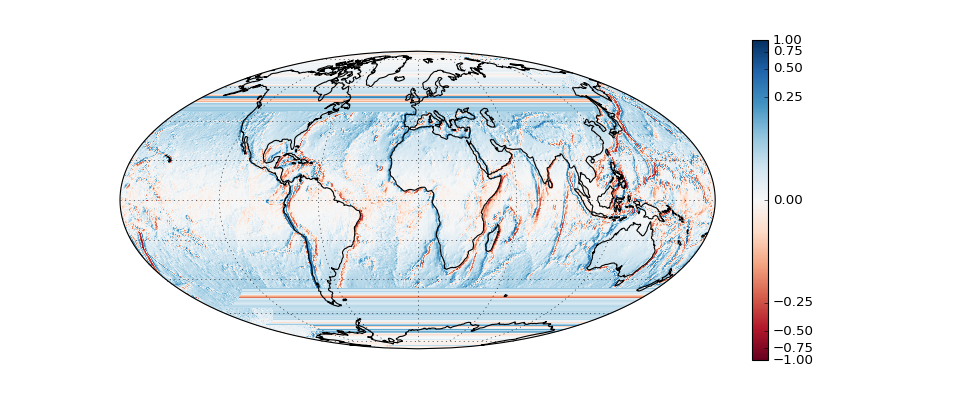

In [29]:
lim = 1  # km

fig = plt.figure(figsize=(12, 5))
ax = plt.axes(projection=ccrs.Mollweide())
for slice_number, (lat_grid, lon_grid, r_grid, data_grid) in enumerate(all_slice):
    mesh = ax.pcolormesh(lon_grid, lat_grid, r_grid * R_EARTH_KM - (R_EARTH_KM - 35),
                         vmin=-lim, vmax=lim, cmap='RdBu', transform=ccrs.PlateCarree(),
                         norm=mcolors.SymLogNorm(0.1))
ax.gridlines()
ax.coastlines()
ax.set_global()
fig.colorbar(mesh);

## At 125 km

In [30]:
lat_grid15_125, lon_grid15_125, r_grid15_125, data_grid15_125 = load_surface_grid(
    'DATABASES_MPI',
    's40rts_fa_l_T40-120s',
    15,
    'bulk_betah',
    R_EARTH - 125e3)

<IPython.core.display.Javascript object>


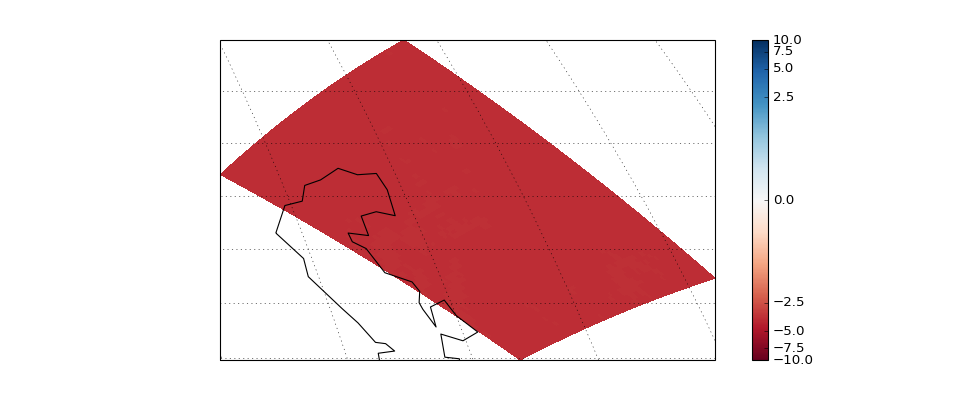

In [31]:
lim = 10  # km

fig = plt.figure(figsize=(12, 5))
ax = plt.axes(projection=ccrs.Mollweide())
mesh = ax.pcolormesh(lon_grid15_125, lat_grid15_125, r_grid15_125 * R_EARTH_KM - (R_EARTH_KM - 125),
                     vmin=-lim, vmax=lim, cmap='RdBu', transform=ccrs.PlateCarree(),
                     norm=mcolors.SymLogNorm(1))
ax.gridlines()
ax.coastlines()
# ax.set_global()
fig.colorbar(mesh);

# Load all visible slices and place in grid

In [32]:
def load_kernel_surface(slices, rotation, topo_dir, kernel_dir, prop, depth_in_km):
    slice_radius = R_EARTH - depth_in_km * 1e3
    slice_height, slice_width = determine_surface_shape(slice_radius)
    height = (slice_height - 1) * slices.shape[0] + 1
    width = (slice_width - 1) * slices.shape[1] + 1

    lat = np.zeros((height + 1, width + 1))
    lon = np.zeros_like(lat)
    data = np.zeros((height, width))
    mask = np.zeros_like(data, dtype=np.bool_)

    process_pool = Pool()

    it = np.nditer(slices, flags=['multi_index'])
    results = []
    for this_slice in it:
        row, col = it.multi_index

        row_offset = row * (slice_height - 1)
        col_offset = col * (slice_width - 1)

        if this_slice == -1:
            mask[row_offset:row_offset + slice_height,
                 col_offset:col_offset + slice_width] = True
            continue

        ret = process_pool.apply_async(load_surface_grid,
                                       args=(topo_dir, kernel_dir, this_slice, prop, slice_radius))
        results.append((row, col, row_offset, col_offset, ret))

    process_pool.close()
    process_pool.join()

    for row, col, row_offset, col_offset, ret in results:
        lat_grid, lon_grid, r_grid, data_grid = ret.get()
        rot = rotation[row, col]

        lat[row_offset:row_offset + slice_height + 1,
            col_offset:col_offset + slice_width + 1] = np.rot90(lat_grid, rot)

        lon[row_offset:row_offset + slice_height + 1,
            col_offset:col_offset + slice_width + 1] = np.rot90(lon_grid, rot)

        data[row_offset:row_offset + slice_height,
             col_offset:col_offset + slice_width] = np.rot90(data_grid, rot)

    data = np.ma.MaskedArray(data, mask)
    return lat, lon, data

# All kernels

In [33]:
DEPTHS = [35, 125]
UNDO_TYPES = ['fa', 'pd']
WAVE_TYPES = [('', 'bulk_betav'), ('_l', 'bulk_betah')]
FILTERS = ['40-60s', '40-120s']
# 's40rts_%s%s_%s' % (UNDO_TYPES, WAVE_TYPE, FILTERS)

In [34]:
with np.load('slices.npz') as data:
    slices = data['grid']
    rotation = data['rotation']

In [35]:
topo_dir = 'DATABASES_MPI'

all_data = defaultdict(lambda : defaultdict(lambda : defaultdict(dict)))
for depth in tqdm(DEPTHS, desc='depths'):
    for undo_type in tqdm(UNDO_TYPES, desc='undo types', nested=True):
        for wave_type, matprop in tqdm(WAVE_TYPES, desc='wave', nested=True):
            for filt in tqdm(FILTERS, desc='filters', nested=True):
                kernel_dir = 's40rts_%s%s_T%s' % (undo_type, wave_type, filt)

                lat, lon, data = load_kernel_surface(slices, rotation,
                                                     topo_dir, kernel_dir,
                                                     matprop, depth)

                all_data[depth][undo_type][wave_type][filt] = (lat, lon, data)

wave:  50%|█████     | 1/2 [05:41<05:41, 341.89s/it]


In [36]:
for depth in DEPTHS:
    for undo_type in UNDO_TYPES:
        for wave_type, matprop in WAVE_TYPES:
            for filt in FILTERS:
                filename = os.path.join('s40rts_%s%s_T%s' % (undo_type, wave_type, filt),
                                        'reg_1_depth%d_%s_kernel.npz' % (depth, matprop))
                lat, lon, data = all_data[depth][undo_type][wave_type][filt]
                np.savez_compressed(filename,
                                    latitude=lat, longitude=lon,
                                    kernel=data.data, kernel_mask=data.mask)

# License Statement
Copyright (C) 2016  Elliott Sales de Andrade

This program is free software; you can redistribute it and/or
modify it under the terms of the GNU General Public License
as published by the Free Software Foundation; either version 2
of the License, or (at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with this program; if not, write to the Free Software
Foundation, Inc., 51 Franklin Street, Fifth Floor, Boston, MA  02110-1301, USA.